In [210]:
import pandas as pd
import yfinance as yf
import numpy as np

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [212]:
commodities = ["CL=F", "NG=F", "BZ=F", "GC=F", "SI=F", "PA=F", "PL=F", "HG=F"]

In [213]:
data = yf.download(commodities,start='2021-01-01')

[*********************100%***********************]  8 of 8 completed


In [214]:
data = data['Adj Close']

In [215]:
data

,BZ=F,CL=F,GC=F,HG=F,NG=F,PA=F,PL=F,SI=F
Date,,,,,,,,
2021-01-04,51.090000,47.619999,1944.699951,3.5530,2.581,2385.899902,1066.000000,27.284000
2021-01-05,53.599998,49.930000,1952.699951,3.6405,2.702,2488.100098,1114.699951,27.570999
2021-01-06,54.299999,50.630001,1906.900024,3.6500,2.716,2442.800049,1105.699951,26.973000
2021-01-07,54.380001,50.830002,1912.300049,3.6955,2.729,2426.300049,1119.699951,27.200001
2021-01-08,55.990002,52.240002,1834.099976,3.6735,2.700,2359.699951,1065.699951,24.582001
...,...,...,...,...,...,...,...,...
2023-06-02,76.129997,71.739998,1952.400024,3.7225,2.172,1386.800049,1011.599976,23.643000
2023-06-05,76.709999,72.150002,1958.000000,3.7625,2.245,1395.500000,1044.500000,23.534000
2023-06-06,76.290001,71.739998,1965.500000,3.7670,2.262,1396.599976,1046.800049,23.573999


In [216]:
data.fillna(method="ffill", inplace=True)

In [217]:
def get_ts_mom_strategy_returns(data, lookback,hold, freq):
    df = pd.DataFrame()
    data = data.asfreq(freq, method='ffill')
    df['lookback_returns'] = data.pct_change(lookback)
    df['hold_returns'] = data.pct_change(hold).shift(-hold)
    df = df.dropna()
    df['positions'] = np.where(df['lookback_returns'] > 0, 1, -1)
    df['strategy_returns'] = df['hold_returns'] * df['positions']

    return df['strategy_returns']

In [218]:
def analytics_returns(data_strategy_returns, title_name):

    sharpe = (np.mean(data_strategy_returns) /
             np.std(data_strategy_returns)*(12**0.5))
    sharpe.plot.bar(figsize=(10, 7), color='blue')
    plt.ylabel('Sharpe')
    plt.title(title_name)
    plt.show()

    # Calculate the cumulative strategy returns
    cum_rets = (data_strategy_returns /100 + 1).cumprod()
    cum_rets.plot(figsize=(10, 7))

    # Set title and labels for the plot
    plt.title(title_name, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.show()

    total_months = len(cum_rets)
    analytics = pd.DataFrame()

    # Calculate annalised returns
    analytics['Annualised Returns'] = (cum_rets.iloc[-2]**(12/total_months)-1)*100

    # Calculate annualised volatility
    analytics['Annualised Volatility'] = np.std(data_strategy_returns)*(12**0.5)
    #print(cum_rets[-50:])

    # Calculate maximum drawdown
    def calc_drawdown(cum_rets):

        # Calculate the running maximum
        running_max = np.maximum.accumulate(cum_rets.dropna())

        # Ensure the value never drops below 1
        running_max[running_max < 1] = 1

        # Calculate the percentage drawdown
        drawdown = (cum_rets)/running_max - 1
        return drawdown

    analytics['Max Drawdown'] = cum_rets.apply(calc_drawdown, axis=0).min()*100

    #print(analytics)

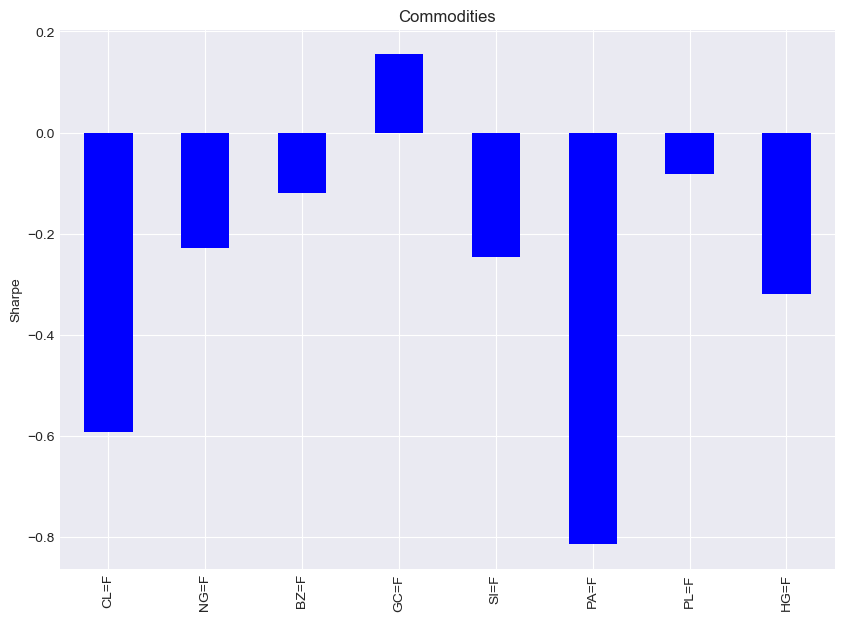

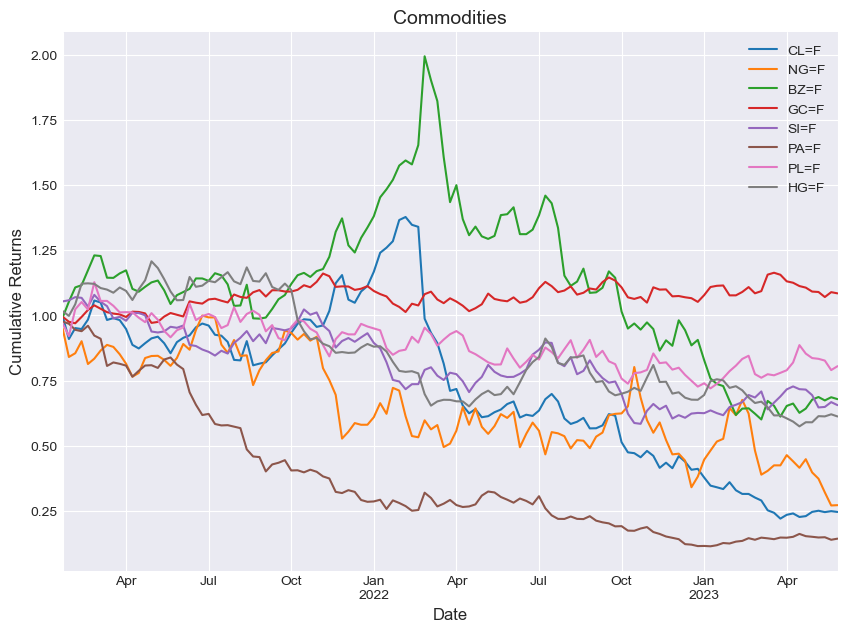

In [219]:
data_strategy_returns = data[commodities].apply(
    get_ts_mom_strategy_returns, lookback=2, freq='w', hold=1, axis=0)*100
#print(data_strategy_returns)
analytics_returns(data_strategy_returns, 'Commodities')